# **1. Configuración inicial**

In [ ]:
import pandas as pd
import numpy as np
from stargazer.stargazer import Stargazer
import scipy as sc
import statsmodels as stats
import arch 
import matplotlib.pyplot as plt
import os 
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

stg = importr('stargazer')

if os.getcwd().split('\\')[len(os.getcwd().split('\\'))-1] != "202510-Series-Taller2":
    os.chdir("..")
print(os.getcwd())

c:\Users\NicolasLozano\OneDrive - Universidad de los andes\UNIVERSIDAD\9. NOVENO SEMESTRE\SERIES DE TIEMPO\TALLERES\202510-Series-Taller2


## **2.a. Cargue de datos, transformación y grafico de la serie**

In [3]:
data_trm = pd.read_excel("data\\TRM.xlsx")

data_trm = data_trm.rename(columns={'Fecha (dd/mm/aaaa)':'date','Tasa de cambio representativa del mercado (TRM)':'trm'})

# Cobnnvertimos la columna fecha a datetime.
data_trm['date'] = pd.to_datetime(data_trm['date'], format='%Y/%m/%d')\

# Especificamos que la columna date debe tomarse como index.
data_trm.set_index('date', inplace=True)

# Se especifica que la frecuencia es diaria.
data_trm = data_trm.asfreq('D')

print(data_trm)

                trm
date               
1991-12-01   643.42
1991-12-02   643.42
1991-12-03   639.22
1991-12-04   635.70
1991-12-05   631.51
...             ...
2025-03-21  4187.72
2025-03-22  4168.82
2025-03-23  4168.82
2025-03-24  4168.82
2025-03-25  4168.82

[12169 rows x 1 columns]


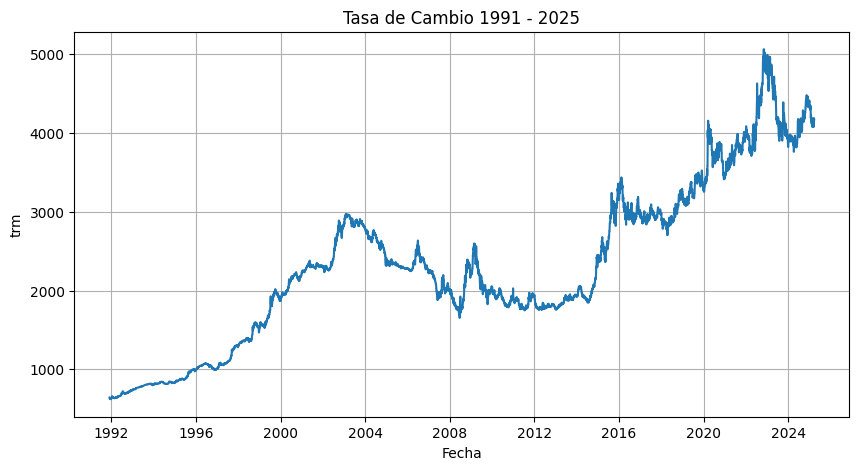

In [4]:
os.makedirs(".\\output", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(data_trm.index,data_trm['trm'],linestyle='-')
plt.xlabel('Fecha')
plt.ylabel('trm')
plt.title('Tasa de Cambio 1991 - 2025')
plt.grid(True)
plt.savefig("output\\graf_trm.png", dpi=300, bbox_inches='tight')
plt.show()

## **2.b. Retorno de la trm**

In [37]:
data_trm['retorno']=(np.log(data_trm['trm'])-np.log(data_trm['trm'].shift(1)))*100

ret_promedio = pd.DataFrame({"Estad\\'istico": ["Retorno Promedio"], "Valor": [data_trm['retorno'].mean()]})

latex_table = ret_promedio.to_latex(index=False, label="tab:retorno_promedio", na_rep='0',multicolumn=True,position='H')
latex_table = latex_table.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
latex_table = latex_table.replace("\\end{tabular}", f"\\end{{tabular}}\n\\caption{{Retorno Promedio}}")

with open("output\\retorno_promedio.tex", "w") as f:
     f.write(latex_table)



## **2.b Retornos sin media al cuadrado**

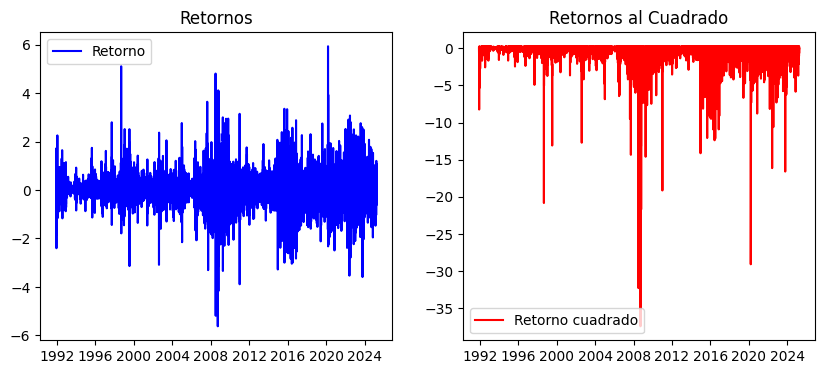

In [43]:
data_trm['retorno2']=data_trm['retorno']-np.square(data_trm['retorno']-data_trm['retorno'].mean())
data_trm['retorno_sin_media']=data_trm['retorno']-data_trm['retorno'].mean()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(data_trm.index,data_trm['retorno'],linestyle='-', label="Retorno", color="b")
ax[0].set_title("Retornos")
ax[0].legend()

ax[1].plot(data_trm.index,data_trm['retorno2'],linestyle='-', label="Retorno cuadrado", color="r")
ax[1].set_title("Retornos al Cuadrado")
ax[1].legend()
plt.savefig("output\\subplot_retornos.png", dpi=300, bbox_inches='tight')
plt.show()
